# Problem Statement

## Context:

AllLife Bank aims to optimize its credit card customer base in the upcoming financial year. To achieve this goal, the bank's Marketing and Operations teams have identified two key areas for improvement. The Marketing team plans to implement personalized campaigns to attract new customers and increase upselling to existing customers. Meanwhile, the Operations team intends to enhance the service delivery model to address customer concerns more efficiently. Both teams have reached out to the Data Science team for assistance in achieving these objective

### Objective:

This project aims to identify customer segments within AllLife Bank's existing customer base using clustering algorithms. By analyzing spending patterns and past interactions, the project will provide recommendations to enhance marketing and service strategies for each segment, leading to improved customer satisfaction and business growth.


#### Questions to be Answered:

1) Can we identify distinct customer segments within AllLife Bank's credit card customer base?

2) What are the key demographic, transactional, and behavioral attributes that differentiate these customer segments?

3) How can personalized marketing campaigns be developed to target and attract new customers?

4) How can existing customers be effectively upsold to increase their engagement and usage of credit card services?

5) What are the main pain points and areas of improvement in the current customer support services?

6) How can the service delivery model be upgraded to resolve customer queries faster and enhance customer satisfaction?

##### Data Background:

The provided dataset contains information about customers from a bank, including their financial attributes such as credit limit and the number of credit cards they possess. It also includes data about the different channels through which customers have reached out to the bank for queries, including in-person visits, online interactions, and contact through the call center. This dataset will be utilized to analyze customer behavior, identify patterns, and make data-driven decisions to enhance marketing strategies and improve customer service at the bank.

### Data Dictionary

- Sl_No: Primary key of the records

- Customer Key: Customer identification number

- Average Credit Limit: Average credit limit of each customer for all credit cards

- Total credit cards: Total number of credit cards possessed by the customer

- Total visits bank: Total number of visits that customer made (yearly) personally to the bank

- Total visits online: Total number of visits or online logins made by the customer (yearly)

- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Import necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for efficient iteration and combination of elements
import itertools

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to perform k-means, DBSCAN clustering and compute silhouette scores
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# to compute distances
from scipy.spatial.distance import cdist

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
#!pip install openpyxl

In [3]:
# Load Dataset
ccd = pd.read_excel("Credit+Card+Customer+Data.xlsx")
ccd.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


The five rows provided in the dataset represent information for five different customers. Each row corresponds to a unique customer and provides their financial attributes and interaction history with the bank.

In [4]:
# check dimension of dataset
ccd.shape

(660, 7)

The dataset has 660 rows and 7 columns

In [5]:
# create a copy of the original data
cd = ccd.copy()

In [6]:
# Finding duplicates
cd.duplicated().sum()

0

In [7]:
#check the data structure
cd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


The DataFrame contains 660 rows (entries) and 7 columns in the DataFrame, each representing a different attribute.
The "Non-Null Count" indicates the number of non-null values present in each column. In this case, all columns have a count of 660, indicating that there are no missing values in the dataset.All the columns are integer datatype

In [8]:
# check missing value
cd.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

There are no missing values in the Credit Card dataset

In [9]:
# dropping the serial no. column and customer key as it does not provide any information
cd.drop(["Sl_No","Customer Key"], axis = 1, inplace = True)

In [10]:
# Find the unique values

cd.nunique()

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [11]:
# descriptive computational analysis
cd.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


The mean values of Avg_Credit_Limit, Total_Credit_Cards, Total_visits_bank, Total_visits_online, Total_calls_made are approximately 34574.24, 4.71, 2.40, 2.61 and 3.58 respectively.

The standard deviation of Avg_Credit_Limit, Total_Credit_Cards, Total_visits_bank, Total_visits_online, Total_calls_made is 37625.49, 2.17, 1.63, 2.94 and 2.87 respectively.

### Exploratory Data Analysis

##### Univariate Analysis

In [12]:
# select the numerical features as a list of numerical columns
num_col = cd.select_dtypes(include= np.number).columns.tolist()

num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [13]:
from utils import histogram_boxplot

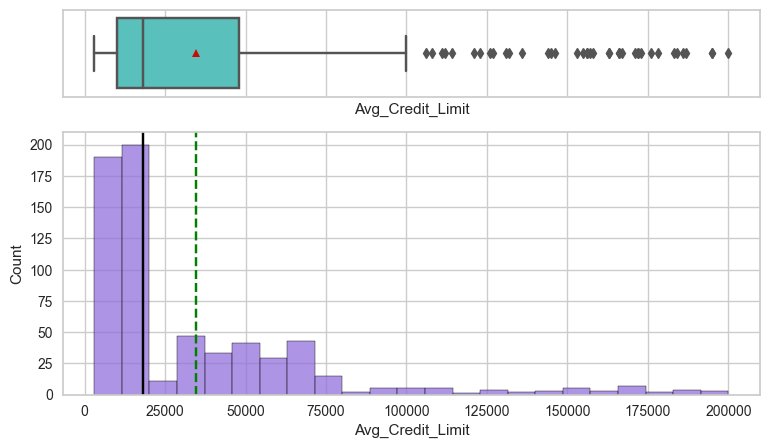

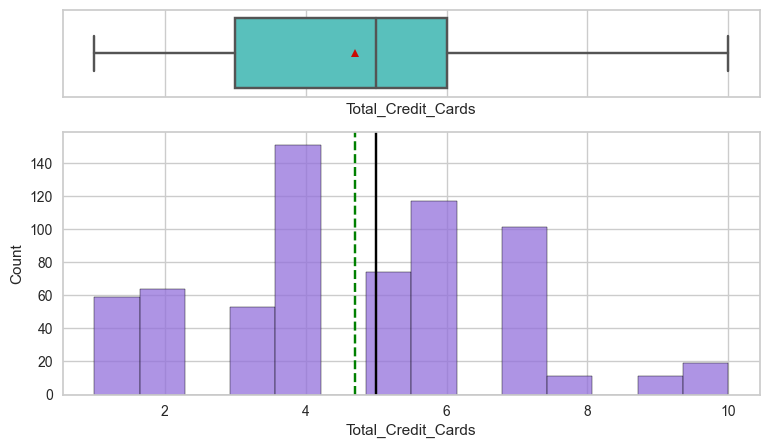

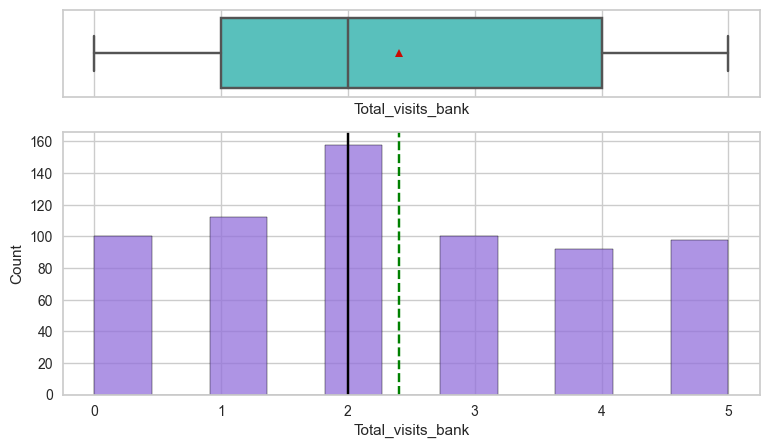

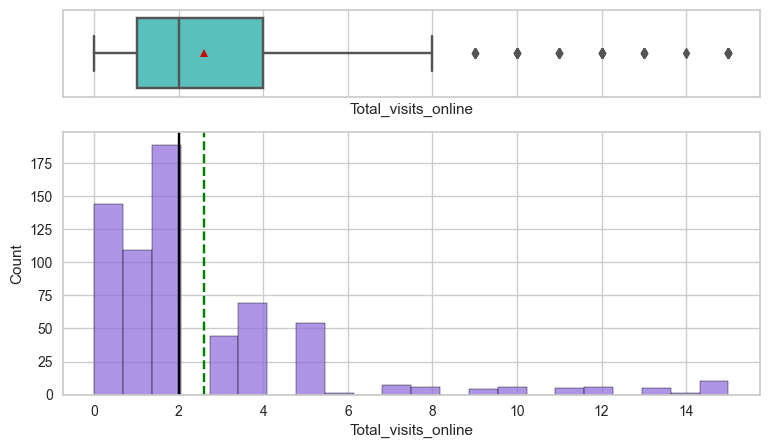

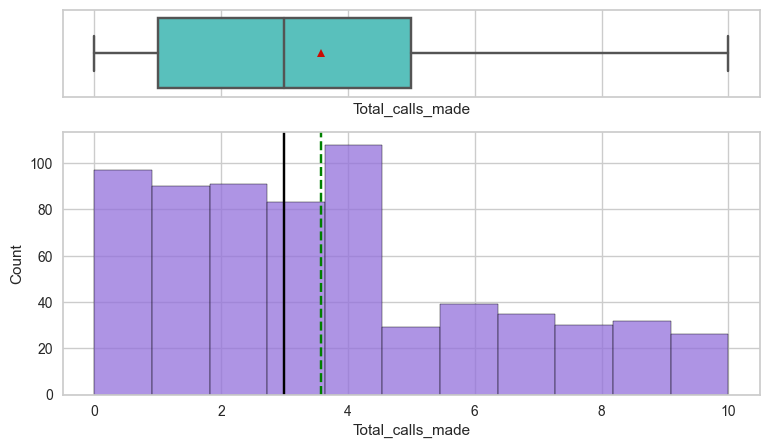

In [14]:
for item in num_col:
    histogram_boxplot(cd, item)

Average Credit Limit, Total Bank Visits, Total Online Visits and Total Calls made are all rightly skewed whereas Total Credit calls is left skewed.

The dataset contains outliers for the average credit limit, indicating that there are several customers with higher credit limits. These outliers can provide valuable insights for further analysis and should be considered in the analysis.

On the other hand, the outliers for total visits online can be removed from the dataset. These outliers may be unusual data points that deviate significantly from the majority of observations, and their removal can help ensure more accurate analysis and modeling for KMeans.

##### Bivariate Analysis

In [15]:
# Let's check for correlations
num_data = cd[num_col]

cor = num_data.corr()
cor


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


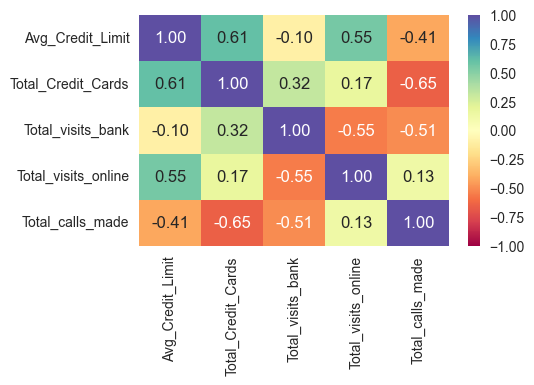

In [16]:
plt.figure(figsize=(5, 3))
sns.heatmap(cor, vmin = -1, vmax = 1, cmap = "Spectral", annot=True, fmt=".2f")
plt.show()

The heatmap Plot shows there is moderate positive correlation between Average Credit Limit and Total Credit Cards of 0.61. This could suggest that as the average credit limit increases, the total number of credit cards also tends to increase.

The heat map also shows that total bank visits have negation relationship with the total visits made online (-0.55) and total calls (-0.51) made
Total calls made also have a negative correlation with the Total number of credit cards (-0.65). 

Also, a negative correlation between "Avg_Credit_Limit" and "Total_calls_made" of -0.41, indicating a moderate negative correlation. As the average credit limit increases, the number of calls made to the customer service tends to decrease

A No or Weak Correlation correlation between "Avg_Credit_Limit" and "Total_visits_bank" of -0.10, indicating a weak negative correlation. The average credit limit and the number of visits to the bank do not show a strong linear relationship.

## Treating Outliers

In [17]:
# Function to treat outliers in numerical variables using IQR method
def treat_outliers(cd, col):
    """
    Treat outliers in numerical variables
    df: DataFrame
    col: str, name of the numerical variable
    """
    Q1 = cd[col].quantile(0.25) # first quartile
    Q3 = cd[col].quantile(0.75) # third quartile
    IQR = Q3 - Q1 # interquartile range
    lower_whisker = Q1 - (1.5 * IQR) # calculate lower whisker
    upper_whisker = Q3 + (1.5 * IQR) # calculate upper whisker
    cd[col] = np.clip(cd[col], lower_whisker, upper_whisker) # clip the values of the variable between the lower and upper whisker
    return cd

In [18]:
# Function to treat outliers in all numerical variables of a DataFrame
def treat_outliers_all(cd, col_list):
    """
    Treat outliers in all numerical variables of a DataFrame
    df: DataFrame
    col_list: list of str, names of the numerical variables
    """
    for c in col_list:
        cd = treat_outliers(cd, c)
    return cd

In [19]:
cd = treat_outliers_all(cd, num_data)

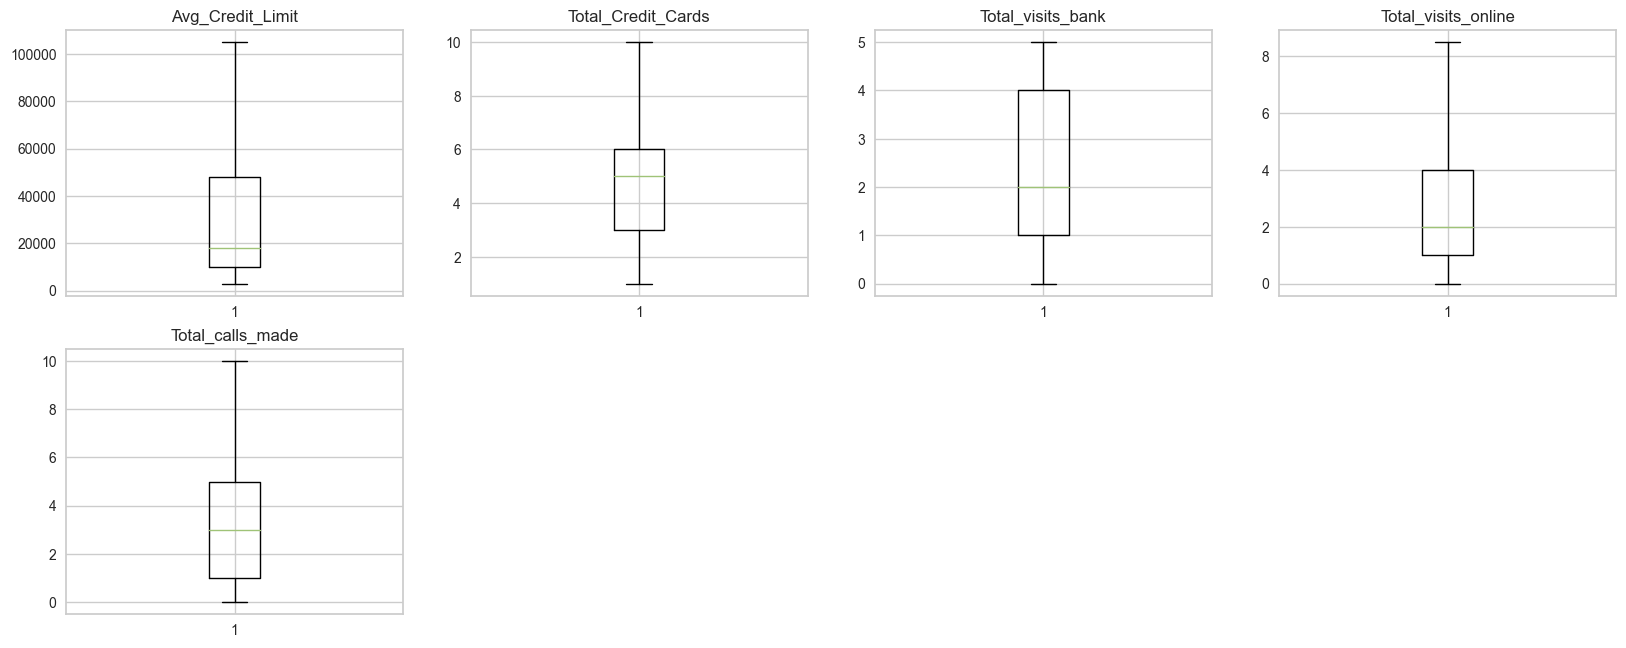

In [20]:
plt.figure(figsize = (20, 20))

for i, variable in enumerate (num_data):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(cd[variable], whis = 1.5)
    plt.title(variable)

plt.savefig("cd_outlier_treated_plots.png")
plt.show()

Outliers have been treated by clipping

### KMeans Clustering

In [21]:
# Select the relevant columns for clustering
num_data = cd[num_col]

In [22]:
# scaling the dataset before clustering

scaler = StandardScaler()
num_data_sd = scaler.fit_transform(num_data)

In [23]:
# Perform k-means clustering
kmeans = KMeans(n_init=10, random_state=0)

kmeans.fit(num_data_sd)

KMeans(n_init=10, random_state=0)

In [24]:
kmeans.inertia_

561.2456156742842

In [25]:
y_pred = kmeans.predict(num_data_sd)

y_pred

array([3, 7, 3, 4, 2, 6, 2, 6, 6, 6, 1, 6, 7, 1, 1, 1, 6, 1, 6, 7, 1, 1,
       1, 6, 7, 7, 7, 7, 1, 1, 1, 1, 7, 1, 7, 1, 7, 1, 7, 7, 7, 6, 6, 1,
       1, 7, 6, 6, 7, 6, 7, 1, 7, 7, 7, 6, 6, 7, 1, 7, 1, 7, 6, 1, 7, 1,
       1, 6, 7, 6, 1, 6, 6, 6, 7, 1, 1, 1, 7, 6, 7, 1, 6, 1, 1, 1, 6, 6,
       7, 7, 1, 7, 1, 1, 1, 1, 6, 1, 7, 1, 1, 7, 7, 1, 7, 7, 1, 6, 6, 7,
       6, 7, 7, 6, 1, 6, 6, 1, 1, 7, 1, 7, 6, 7, 6, 1, 7, 7, 1, 1, 1, 6,
       6, 7, 1, 6, 7, 7, 7, 7, 7, 1, 7, 1, 7, 1, 7, 1, 7, 6, 7, 1, 6, 1,
       7, 1, 1, 7, 7, 6, 7, 1, 1, 7, 7, 7, 1, 6, 7, 1, 7, 6, 1, 7, 6, 6,
       6, 7, 1, 6, 1, 7, 1, 7, 6, 1, 6, 7, 1, 6, 7, 6, 1, 7, 1, 7, 7, 6,
       1, 7, 7, 7, 7, 1, 1, 1, 6, 1, 7, 7, 1, 1, 6, 7, 7, 1, 1, 6, 1, 7,
       7, 1, 7, 7, 7, 6, 7, 7, 4, 4, 0, 4, 0, 4, 0, 0, 0, 0, 4, 4, 4, 0,
       4, 0, 4, 4, 0, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4, 0, 4, 0, 0, 4, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0,
       0, 4, 4, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0,

In [26]:
silhouette_score(num_data_sd, y_pred)

0.2559645178889122

With 8 clusters, Silhouette score is 0.26

#### Choose optimal number of clusters

Number of Clusters: 1 	Average Distortion: 2.0731463576129583
Number of Clusters: 2 	Average Distortion: 1.4986141501796377
Number of Clusters: 3 	Average Distortion: 1.1823298853410935
Number of Clusters: 4 	Average Distortion: 1.0711026440504199
Number of Clusters: 5 	Average Distortion: 1.0049111763726386
Number of Clusters: 6 	Average Distortion: 0.9522480603748492
Number of Clusters: 7 	Average Distortion: 0.9148516542777971
Number of Clusters: 8 	Average Distortion: 0.8916162554842096


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

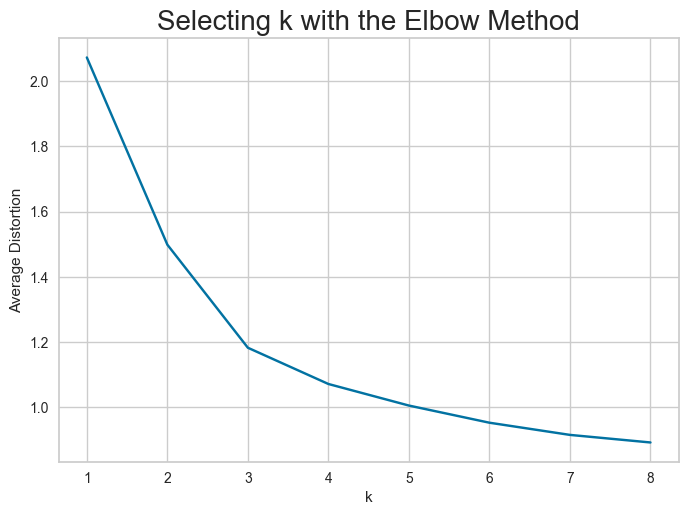

In [27]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k, n_init=10)  # Initialize KMeans
    model.fit(num_data_sd)  # Fit kMeans on the scaled data
    prediction = model.predict(num_data_sd)  # Predict the model on the scaled data
    distortion = (
        sum(np.min(cdist(num_data_sd, model.cluster_centers_, "euclidean"), axis=1))
        / num_data_sd.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

We can pick between 2 to 4 groups looking at the elbow curve. We will look at Silhouette score to have a better decision

#### Silhouette score

For n_clusters = 2, silhouette score is 0.4201583924929177
For n_clusters = 3, silhouette score is 0.5169867470092899
For n_clusters = 4, silhouette score is 0.38147048130671246
For n_clusters = 5, silhouette score is 0.35332888701008774
For n_clusters = 6, silhouette score is 0.27144074102275517
For n_clusters = 7, silhouette score is 0.267309709474857
For n_clusters = 8, silhouette score is 0.2530106315718339
For n_clusters = 9, silhouette score is 0.24596916800902668


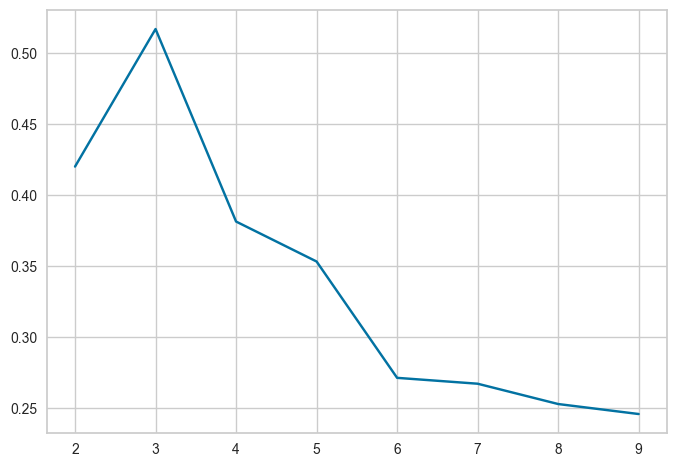

In [28]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, n_init=10)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((num_data_sd))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(num_data_sd, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

From the silhouette scores, it seems that 3 is a good value of k for appropriate number of clusters

### Applying KMeans clustering for k=3

In [29]:
kmeans1 = KMeans(n_clusters=3, random_state=0, n_init= 10)
kmeans1.fit(num_data_sd)

KMeans(n_clusters=3, n_init=10, random_state=0)

In [30]:
kmeans1.labels_

array([0, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
# adding kmeans cluster labels to the original dataframe
cd["Kmeans_clusters"] = kmeans1.labels_

In [32]:
#checking colums
cd.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made', 'Kmeans_clusters'],
      dtype='object')

### Visualizing groups

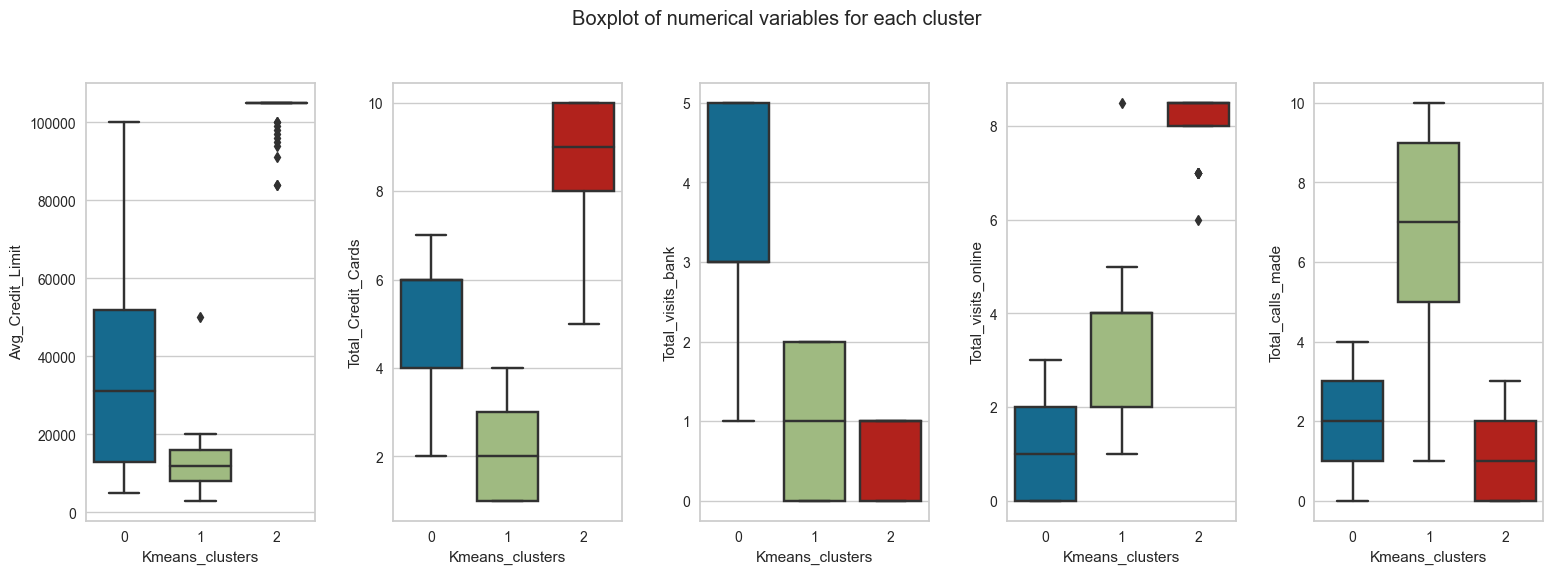

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=cd[num_col[counter]], x=cd["Kmeans_clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

Cluster 0
Has customers with moderate Average credit limit with moderate credit cards. This customer segment also make frequent visit to the Bank. They have the least  online visits and moderate calls to the bank. 

Customer experience can be increased by their interaction with the Relationship Manager or Branch Manager as they tend to visit the Bank.Through interaction they can be encouraged to patronize online services.


Cluster 1
Has the least average credit limit, least credit cards, moderate bank visits, moderate online interaction and make the most calls. 


Cluster 2
Has the customers with high extreme average credit score with more credit cards and also with the highest online interactions.They have the least total visits and calls to Bank. 

In [34]:
cd.query("Kmeans_clusters == 2")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmeans_clusters
4,100000,6,0,8.5,3,2
6,100000,5,0,8.5,2,2
612,105000,9,1,8.5,1,2
613,94000,9,1,8.5,0,2
614,105000,8,1,7.0,1,2
615,105000,9,1,8.5,1,2
616,96000,10,1,8.5,2,2
617,105000,8,0,8.5,0,2
618,105000,7,0,8.5,2,2
619,105000,7,0,8.5,0,2


These indicate Cluster 2 customers are premium class of customers. They could be the 20 in the 80/ 20 Pareto principle.

Providing exceptional value, exclusivity, and personalized attention should be key.

In [35]:
cd.query("Kmeans_clusters == 1")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmeans_clusters
1,50000,3,0,8.5,9,1
5,20000,3,0,1.0,8,1
7,15000,3,0,1.0,1,1
8,5000,2,0,2.0,2,1
9,3000,4,0,1.0,7,1
...,...,...,...,...,...,...
224,12000,4,1,5.0,9,1
225,16000,4,1,2.0,5,1
226,8000,1,2,4.0,8,1
227,8000,2,2,3.0,8,1


Frequent calls and follow up from the Bank will help retain these customers and form marketing strategy based on it.


In [36]:
cd.query("Kmeans_clusters == 0")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmeans_clusters
0,100000,2,1,1.0,0,0
2,50000,7,1,3.0,4,0
3,30000,5,1,1.0,4,0
228,10000,7,2,0.0,0,0
229,8000,7,2,1.0,4,0
...,...,...,...,...,...,...
607,34000,6,3,1.0,0,0
608,47000,4,4,1.0,0,0
609,38000,4,3,2.0,0,0
610,39000,7,2,1.0,0,0


They could be encouraged to increase their spending and gradually convert a percentage into premium customers.

### DBSCAN Clustering

In [37]:
# create instance of DBSCAN
dbscan = DBSCAN()


# fit and predict the labels
db_labels = dbscan.fit_predict(num_data_sd)

In [38]:
# check the labels
np.unique(db_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33], dtype=int64)

### Choosing optimal values of eps and minPts

In [39]:
#try values of eps btn 0.1 and 1; minPts btn 2 and 10

eps = np.linspace(0.1, 1, 10)

minPts = np.arange(2, 10)

In [40]:
# create a tuple of eps and MinPts using product method of itertools
hyper_list= list(itertools.product(eps, minPts))

#### Silhouette score

In [41]:
for eps, minPts in hyper_list:
    dbscan = DBSCAN(eps=eps, min_samples=minPts)
    labels = dbscan.fit_predict(num_data_sd)
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        score = silhouette_score(num_data_sd, labels)
        print(f"eps: {eps}; minPts: {minPts}; num_labels: {len(unique_labels)}; score: {score}")


eps: 0.1; minPts: 2; num_labels: 61; score: -0.40162585833700315
eps: 0.1; minPts: 3; num_labels: 5; score: -0.44547010061930037
eps: 0.1; minPts: 4; num_labels: 2; score: -0.027709789950855414
eps: 0.2; minPts: 2; num_labels: 87; score: -0.27918459473434387
eps: 0.2; minPts: 3; num_labels: 15; score: -0.49404408270471006
eps: 0.2; minPts: 4; num_labels: 5; score: -0.3790222716291855
eps: 0.30000000000000004; minPts: 2; num_labels: 107; score: -0.18758493082831712
eps: 0.30000000000000004; minPts: 3; num_labels: 28; score: -0.47332529702988263
eps: 0.30000000000000004; minPts: 4; num_labels: 8; score: -0.4193002844554995
eps: 0.4; minPts: 2; num_labels: 135; score: 0.004795176073165545
eps: 0.4; minPts: 3; num_labels: 61; score: -0.21301925444430878
eps: 0.4; minPts: 4; num_labels: 32; score: -0.3509555351231038
eps: 0.4; minPts: 5; num_labels: 16; score: -0.41614518730744804
eps: 0.4; minPts: 6; num_labels: 7; score: -0.31093156260731336
eps: 0.5; minPts: 2; num_labels: 72; score: -0.

From the silhouette scores i will go with eps: 1.0; minPts: 3; num_labels: 3; score: 0.3875498242064757 as the appropriate values for eps and min_samples

### Rebuild the DBSCAN model

- Use eps = 1 and minPts = 3

In [42]:
# create instance of DBSCAN
dbscan1 = DBSCAN(eps = 1.0, min_samples = 3)


# fit and predict the labels
db_labels1 = dbscan1.fit_predict(num_data_sd)

In [43]:
# Check the unique values

np.unique(db_labels1)

array([-1,  0,  1], dtype=int64)

In [44]:
# add the dbscan labels to the original data
cd["db_labels"] = db_labels1 

In [45]:
# checking columns

cd.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made', 'Kmeans_clusters',
       'db_labels'],
      dtype='object')

### Visualizing groups

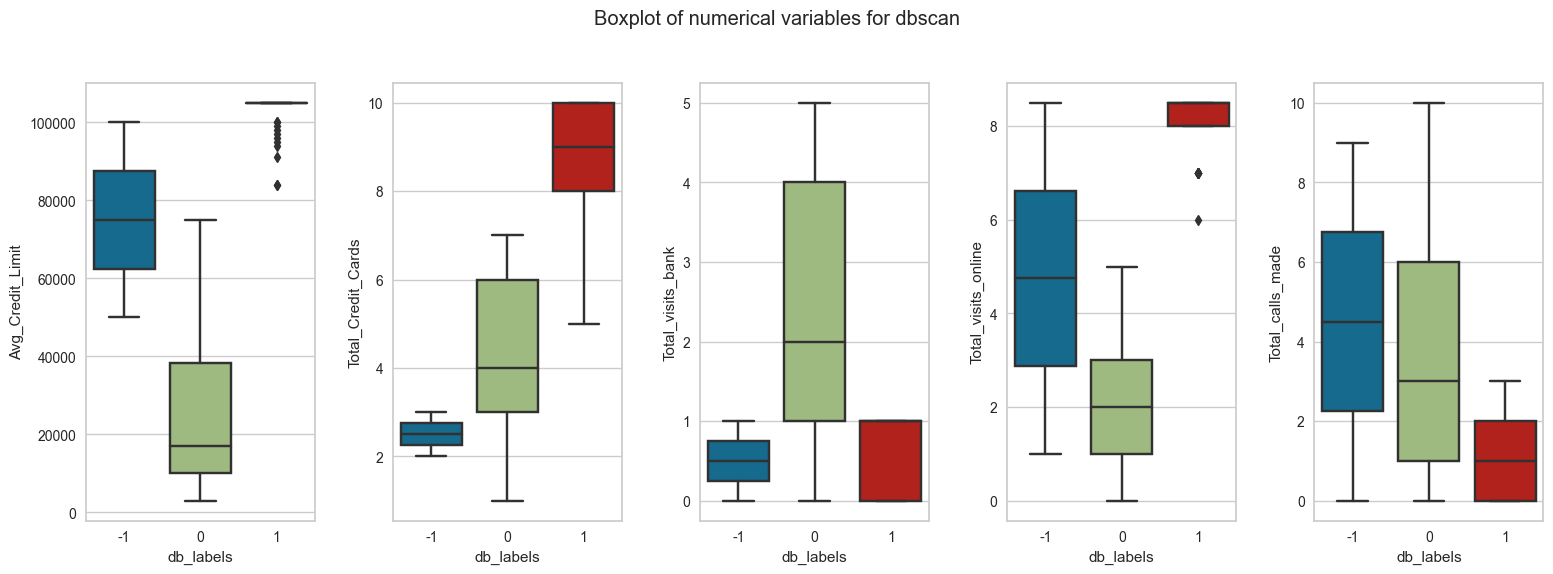

In [46]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for dbscan")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=cd[num_col[counter]], x=cd["db_labels"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

DB_Label -1
Has Average credit score to be high but least total credit cards. Visits to the bank is also the least but have a moderate online interactions and moderate to high calls to the Bank.

DB_Label 0
Has the least average credit score with moderate total credit cards. They tend to frequent the Bank but have the least online interactions and moderate calls to the Bank

DB_Label 1
Has extreme high Average credit limit with high total credit cards. They have the least total visit to the banks and also make the least calls to the Bank but have the highest total online visits. These indicate premium customers where ALL life Bank need to prioritise more. 
The customers as should be targeted for higher profits and their online user experience should be improved with extra features and clean UI to manage cards.

In [47]:
cd.query("db_labels == 1")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmeans_clusters,db_labels
4,100000,6,0,8.5,3,2,1
6,100000,5,0,8.5,2,2,1
612,105000,9,1,8.5,1,2,1
613,94000,9,1,8.5,0,2,1
614,105000,8,1,7.0,1,2,1
615,105000,9,1,8.5,1,2,1
616,96000,10,1,8.5,2,2,1
617,105000,8,0,8.5,0,2,1
618,105000,7,0,8.5,2,2,1
619,105000,7,0,8.5,0,2,1


#### Business  Recommendation for DB_Labels (1)

This Label indicate Premium class of customers. From the query we notice the 50 premium customers that belonged in cluster 2 are exactly the people under the db_label(1) Hence the bank can take the following actions:

1. Personalized Relationship Management: Since customers in db_label 1 are considered premium customers, the bank should prioritize building and maintaining strong relationships with them. Assign dedicated relationship managers who can provide personalized assistance, understand their specific needs, and offer tailored financial solutions.

2. Enhance Online Banking Experience: Given that customers in db_label 1 have the highest total online visits, the bank should focus on continuously improving its online banking platform. This can involve introducing advanced features such as secure and convenient online transactions, personalized dashboards displaying account information, investment tracking tools, and real-time customer support through chat or messaging.

3. Exclusive Rewards and Benefits: Offer exclusive rewards, benefits, and perks to customers in db_label 1. This could include higher cashback percentages, access to premium credit cards with enhanced rewards and privileges, discounted or priority services, and exclusive access to events or partnerships with luxury brands.

4. Customized Investment Opportunities: Recognize the investment potential of customers in db_label 1 and provide them with customized investment opportunities. Offer personalized financial planning services, wealth management advice, and access to exclusive investment products with higher returns and lower risk.

5. VIP Customer Service: Ensure that customers in db_label 1 receive top-notch customer service. This can involve dedicated customer support channels for premium customers, shorter wait times, personalized assistance, and proactive communication to address any concerns or inquiries promptly.

6. High-end Banking Facilities: Create exclusive banking facilities or lounges for customers in db_label 1, providing them with a premium and luxurious banking experience. These facilities can offer privacy, comfort, and additional amenities such as meeting rooms, priority teller services, and access to financial experts.

7. Cross-Selling and Upselling: Leverage the high credit limit and total credit cards of customers in db_label 1 to cross-sell and upsell relevant financial products and services. This could include offering premium insurance packages, mortgage options, investment products, and exclusive travel or lifestyle services.

8. Targeted Marketing Campaigns: Develop targeted marketing campaigns specifically designed to cater to the preferences and needs of customers in db_label 1. Tailor marketing messages and promotions to highlight benefits that resonate with their premium status, such as exclusive offers, personalized services, and superior banking experience.

By implementing these strategies, the bank can further enhance its relationship with premium customers, strengthen customer loyalty, and maximize the value derived from this high-value segment.

In [48]:
cd.query("db_labels == 0")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmeans_clusters,db_labels
2,50000,7,1,3.0,4,0,0
3,30000,5,1,1.0,4,0,0
5,20000,3,0,1.0,8,1,0
7,15000,3,0,1.0,1,1,0
8,5000,2,0,2.0,2,1,0
...,...,...,...,...,...,...,...
607,34000,6,3,1.0,0,0,0
608,47000,4,4,1.0,0,0,0
609,38000,4,3,2.0,0,0,0
610,39000,7,2,1.0,0,0,0


#### Business  Recommendation for DB_Labels (0)

Majority of the Bank's customers are under this db_label(0). Hence the bank can take the following actions:

1) Improve Online Interactions: The bank should focus on enhancing its online banking platform. This could include providing user-friendly features such as easy navigation, quick access to account information, online transaction capabilities, and personalized recommendations based on customer preferences. 

2) Enhance Customer Support Channels: The bank should invest in improving its customer support channels, such as phone support, live chat, or email, to ensure prompt and helpful responses to customer inquiries or concerns. This will curb the perception of poorly support services and ensure customer queries are resolved efficiently, faster and smoothly

3) Offer Credit Education and Management: The bank can provide educational resources or personalized advice on credit management. This could involve offering financial literacy programs, credit counseling services, or tools to monitor and improve credit scores. By empowering customers to better understand and manage their credit, the bank can help them build healthier financial habits.

4) Targeted Marketing and Promotions: The bank can create targeted marketing campaigns and promotions to incentivize their continued frequency to the Bank. This could include special offers, loyalty programs, or personalized recommendations tailored to their banking behaviors and preferences.

5) Improve User Experience:The bank should focus on improving user experience by providing a clean and intuitive user interface (UI) for managing credit cards. This could involve streamlining the card management process, simplifying account information and statements, and offering features that allow customers to easily track and monitor their credit card usage.

6) Personalize Recommendations: Utilize customer data and insights from db_label(0) to offer personalized recommendations for financial products and services. This could include suggesting credit cards that align with their spending patterns, offering tailored loan options, or providing targeted investment opportunities.

By implementing these strategies, the bank can improve customer satisfaction, increase engagement, and potentially help customers in DB_Label 0 manage their credit more effectively.


In [49]:
cd.query("db_labels == -1")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmeans_clusters,db_labels
0,100000,2,1,1.0,0,0,-1
1,50000,3,0,8.5,9,1,-1


#### Business  Recommendation for DB_Labels (-1)

Since there are only two customers in DB_Label -1 with specific characteristics, the bank can consider taking the following actions:

1. Personalized Offers: Analyze the online interactions and call records of these customers to understand their preferences and needs. Based on this information, offer them personalized product recommendations, such as credit cards with attractive benefits or customized loan options that align with their financial goals.

2. Enhanced Online Experience: Since these customers have moderate online interactions, focus on improving the bank's digital platforms and user experience. Enhance the online banking portal or mobile app to provide a seamless and user-friendly interface. This can include features like quick and easy access to account information, secure messaging for customer support, and personalized financial management tools.

3. Targeted Communication: Since these customers make moderate to high calls to the bank, ensure that the customer service representatives are well-trained and equipped to handle their inquiries efficiently. Implement targeted communication strategies to proactively reach out to them with relevant information, such as exclusive offers, updates on new products or services, or personalized financial advice.

4. Credit Limit Increase: Considering that these customers have a high average credit score but the least total credit cards, evaluate their creditworthiness and consider offering them credit limit increases on their existing credit cards. This can help strengthen their loyalty to the bank and provide them with additional financial flexibility.

5. Feedback and Surveys: Engage with these customers to gather their feedback and suggestions regarding their banking experience. Conduct surveys or feedback sessions to understand their needs and expectations better. This information can be valuable for improving the bank's services and addressing any pain points they may have.

It's important for the bank to treat these customers as valuable individuals and provide personalized attention to enhance their overall banking experience.

#### Comparing the K-means models and DBSCAN labels, we can observe the following:

1. Cluster 0 in K-means (386 customers) and DB_Label 0 in DBSCAN (608 customers): These segments are similar, representing customers with moderate average credit score and moderate total credit cards. They tend to frequent the bank but have the least online interactions and moderate calls. The bank can target these customers by encouraging increased spending and providing a better online user experience to enhance their engagement. Reltionship Managers of these customers should often follow up with this customers to maintain their frequency. These customers are likely to bring in referrals.

2. Cluster 1 in K-means (224 customers) and DB_Label -1 in DBSCAN (2 customers): Although in Cluster 1, average credit score is the least with moderate visit to the bank and Db label -1  has moderate to high average credit limit with low total visit to the bank, these segments are similar, representing customers with the least total credit cards. They have moderate online interactions and moderate to high calls to the bank. The bank should focus on providing personalized offers, enhance Customer Support Channels and improving the online experience for these customers to deepen their relationships.



3. Cluster 2 in K-means (50 customers) and DB_Label 1 in DBSCAN (50 customers): These segments are similar, consisting of customers with high average credit limits and high total credit cards. They have the least total visits and calls to the bank but the highest total online visits. These customers indicate premium potential and should be prioritized by the bank. Improving their online user experience and providing additional features can enhance their satisfaction and loyalty.

Based on this recomparison, the bank should prioritize the following actions:

- For customers in Cluster 0 and DB_Label 0, focus on encouraging increased spending, providing a better online user experience, improved relationship management and promoting engagement through personalized offers.

- For customers in Cluster 1 and DB_Label -1, provide personalized offers, enhance the online experience, and strengthen relationships by catering to their specific needs and preferences.

- For customers in Cluster 2 and DB_Label 1, consider them as potential premium customers and prioritize their satisfaction. Enhance their online experience, offer exclusive features, and provide personalized services to further develop their loyalty.

By tailoring strategies to these specific segments, the bank can effectively target customers, improve profitability, clear the negative perception and enhance overall customer satisfaction.